# Convolutional LSTM model for temperature predictions

## By Eva Bendix Nielsen, 
### For master thesis: Predicting climate with Machine learning

In this study a Convolutionl LSTM model is used to predict the annual winter regional temperature for Europe given the global value of total solar irradiance, Carbon dioxide and the volcaninc areosol. The model is borrowed from Shi et al. 2015 but with modifications.

Keras is used for building the model. 

In [ ]:
import keras.layers 
import keras.models
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from pandas import read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot



Before loading the dataset some values needs to be defined. This includes the season for prediction, the batch size, the epoch and much more. The batch size is set to 5 year since the computer is not capable of handeling a value of 10. 

In [ ]:
season = 0                         #0 = 13(Winter, DJF), 1= 14(Spring, MAM), 2= 15 (Summer, JJA), 3= 16 (Autumn, SON)
season_shifted = season + 4        # Defined for the output temperature 

input_batch      = 10              # Size of input to the model
test_train_split = 470             # Years for training
years            = 500             # years in total 
grid_long        = 130             # Lonitudes in grid 
grid_leng        = 70              # Latitudes in grid
training_epoch   = 2               # number of training epochs 
batch_s          = 5              # Batch size

train_batch = test_train_split//input_batch                       # Number of batches for trainig 
test_batch = (years-test_train_split)//input_batch                # Number of batches for testing
test_years = (years-test_train_split)                             # Years for testing

Then the data is loaded. The file DATA_DK_1500_2000_DK_GB.csv contains the values for the three cllimate drivers. The data are divided into a test and training set before scaling to hinder bias in the test set. The temperature is made into two dataset one from 1500 to 1999 and one from 1501 to 2000. This is nedded since the output is the temperture the following year hence a temperature shifted one year ahead. 

In [10]:
dataset_P = read_csv('DATA_DK_1500_2000_DK_GB.csv', header=None, index_col=0) # importing parameters
dataset_P1 = dataset_P.values
dataset_P1 = np.flip(dataset_P1,0)  # flip the direction from 2000--> 1500 to  1500-->2000
dataset_P1 = dataset_P1[1:,:]

data = read_csv('TT_Europe_4.csv', delimiter=';', error_bad_lines=False, index_col=0, header=None)  #importing temperature 

# Defining start and end year 
dataset = data[season:2000:4].values  # Data from 1500 to 1999
dataset_shifted = data[season_shifted :2004:4].values  # Data from 1501 to 2000


# setting sea values higher 
dataset_shifted = np.where(dataset_shifted==-999.990, -50, dataset_shifted)   
dataset = np.where(dataset==-999.990, -50, dataset)   

#Dividing temperature into test and train for both shifted and non shifted
TT_train = dataset[0:test_train_split, 0:dataset.shape[1]]
TT_test = dataset[test_train_split:years, 0:dataset.shape[1]]

TT_train_shifted = dataset_shifted[0:test_train_split, 0:dataset_shifted.shape[1]]
TT_test_shifted = dataset_shifted[test_train_split:years, 0:dataset_shifted.shape[1]]



# Dividing climate drivers into test and train
P_train = dataset_P1[:test_train_split,0:3]
P_test = dataset_P1[test_train_split:years,0:3]


print('Dimensions of training set:')
print(TT_train.shape)
print('And of test set: ')
print(TT_test.shape)



Dimensions of training set:
(470, 9100)
And of test set: 
(30, 9100)


The  next step is to scale the temperature, shifted temperature and climate drivers individual to a value between 0 and 1 using MinMaxScaler fron Scikit-learn.

In [ ]:
# Scaling of temperature 
scaler = MinMaxScaler()
scaler = scaler.fit(TT_train) 
TT_scaled_train = scaler.transform(TT_train) 
TT_scaled_test = scaler.transform(TT_test)

# Scaling of shifted temperature
scaler2 = MinMaxScaler()
scaler2 = scaler2.fit(TT_train_shifted) 
TT_scaled_train_shifted = scaler2.transform(TT_train_shifted)
TT_scaled_test_shifted = scaler2.transform(TT_test_shifted)

# Scaling of climate drivers 
scaler1 = MinMaxScaler()
scaler1 = scaler1.fit(P_train) 
P_scaled_train = scaler1.fit_transform(P_train) 
P_scaled_test = scaler1.transform(P_test)


# Shaping the input data

The input in the Convolution LSTM model is a 5D tensor with the shape: (samples, input_batch, row, columns, channels). Channels is the number of features where temperature for instant is one feature. The next step is therefore to shape the training and test set into this dimension. 

In [ ]:
# Reshape temperature into grid 
TT_train_grid1 = TT_scaled_train.reshape((test_train_split, grid_leng, grid_long))
TT_test_grid1 = TT_scaled_test.reshape((test_years, grid_leng, grid_long,))

# Adding dimension for temperature test set (batch)
TT_test_grid = TT_test_grid1.reshape((1, test_years, grid_leng, grid_long,1))


# Reshape shifted temperature into grid 
TT_train_grid1_shifted = TT_scaled_train_shifted.reshape(test_train_split, grid_leng, grid_long,1)
TT_test_grid1_shifted = TT_scaled_test_shifted.reshape((test_years, grid_leng, grid_long,1))

# Adding dimension for shifted temperature test set (batch)
TT_test_grid_shifted = TT_test_grid1_shifted.reshape((1, test_years, grid_leng, grid_long,1))


# Reshape climate drivers 
P_train_shape=P_scaled_train.reshape((1, test_train_split, 3))
P_test_shape=P_scaled_test.reshape((1, test_years, 3))

# Making an emty grid for the climate drivers in the same dimension at the temperature, 
# but for 3 channels (TSI, CO2 and Volcanic areosol)
P_train_grid = np.zeros((1, test_train_split,grid_leng, grid_long, 3))
P_test_grid = np.zeros((1, test_years, grid_leng, grid_long, 3))

# Inserting the annual values for the climate drivers.
# Same values in all cells (except for water = 0)
for x in range(0,grid_leng): 
    for y in range(0,grid_long):
        for z in range(0,3):
            if TT_train_grid1[1,x,y] == 0: 
                P_train_grid[:,:,x,y,z] = 0           
                P_test_grid[:,:,x,y,z] = 0
            else:
                P_train_grid[:,:,x,y,z] = P_train_shape[:,:,z]            
                P_test_grid[:,:,x,y,z] = P_test_shape[:,:,z] 
            

# Creating empty tensor with 4 channels          
P_train_grid1 = np.zeros((test_train_split, grid_leng, grid_long, 4))   # For training
P_test_grid1 = np.zeros((1, test_years, grid_leng, grid_long, 4))       # For testting 
 
# Inserting the climate drivers and the temperature grid in the new tensor 
P_test_grid1[:,:,:,:,0:3] = P_test_grid                                 # The test parameters 
P_test_grid1[:,:,:,:,3] = TT_test_grid[:,:,:,:,0]                       # the test temperature 

P_train_grid1[:,:,:,0:3] = P_train_grid                                 # The trainings parameters 
P_train_grid1[:,:,:,3] = TT_train_grid1[:,:,:]                          # The test temperature


print('Dimensions of training set:')
print(P_train_grid1.shape)
print('And of test set: ')
print(P_test_grid1.shape)



This is without the batch size. The test set will be saved for after the training and edited later when predicting. The trainingset need to have one more dimension, which will be made in the next step. This step uses a sliding window to create batches that are overlapping. This is important since the amout of data is small and a lot of different batches is needed for traininng.  The shifted temperature needs to have the same amount of batches for the model to know the right result. This is therefore also defined. 

In [ ]:
Shift=3    # how big an overlap in batch. Smaller number equals more batches

Batch_n = (test_train_split-input_batch)//Shift   # The final number of batches


# Creating an empty grid whit the desired dimensions of the training
P_train_grid2 = np.zeros((Batch_n, input_batch, grid_leng, grid_long, 4))

# Creating the batces for the shifted temperature. 
TT_train_grid2_shifted = np.zeros((Batch_n,input_batch, grid_leng, grid_long, 1))
   
# Making the sliding window     
for i in range(Batch_n): 
    g = i*Shift
    P_train_grid2[i,:,:,:,:] = P_train_grid1[g:g+10,:,:,:]
    TT_train_grid2_shifted[i,:,:,:,:] = TT_train_grid1_shifted[g:g+10,:,:]
    
    
print('Dimensions of training input:')
print(P_train_grid2.shape)
print('And dimension of temperature for trainin the model (shifted temperature): ')
print(TT_train_grid2_shifted.shape)
   


The correct tensors are now created for training the model. The trianing have 4 channels which is the 3 climate drivers and the temperature for the previous years which can be defined as x. The shifted temperature have one channel which is the temperature for the year the model shall predict, which can be defined as y. The next step is to create a model that makes the mapping f(x)=y.  

# Defining the model 

The model is borrowed from Shi et al. 2015 but with modifications and it is structured as in the figure.
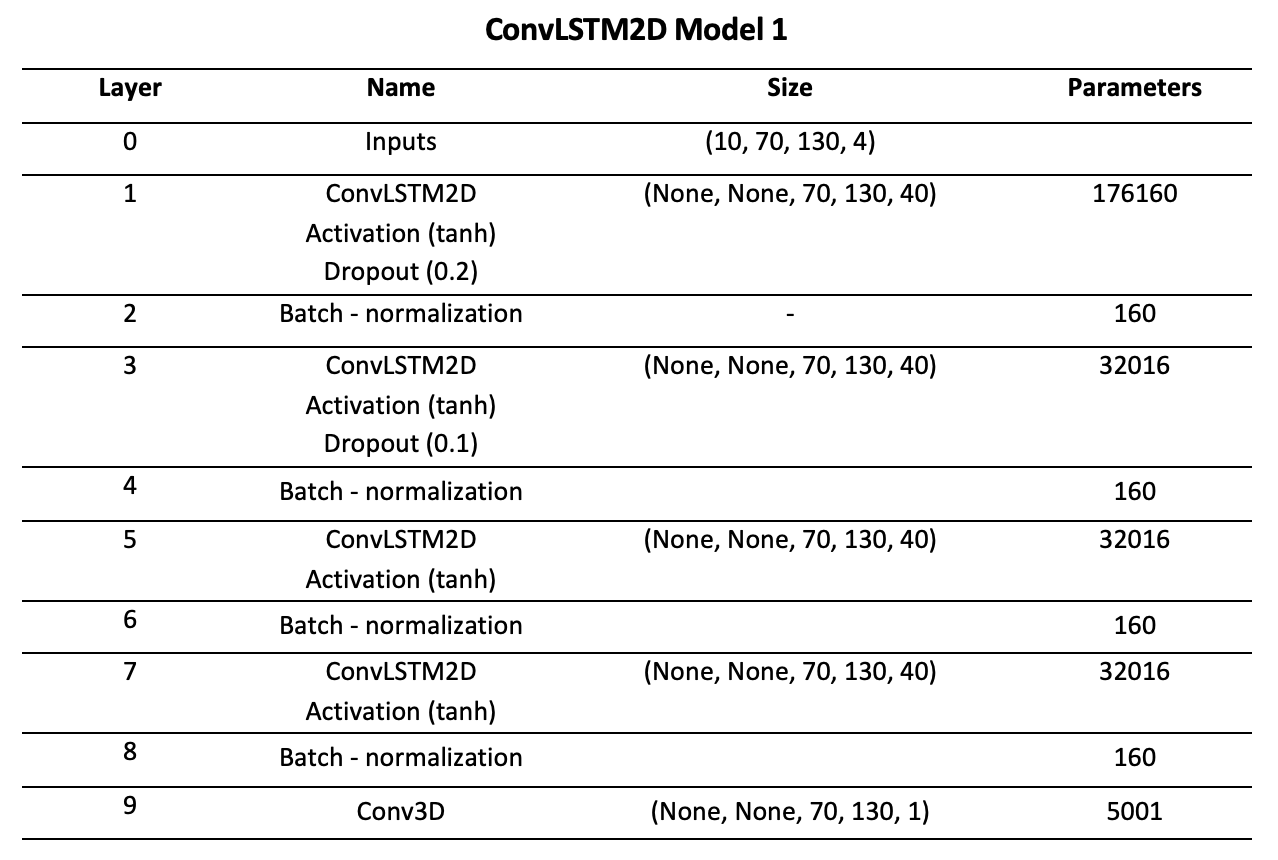

In [ ]:
input_sh = (None, grid_leng, grid_long, 4)

#del seq
#keras.backend.clear_session()

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=input_sh,
                   padding='same', return_sequences=True, dropout=0.1))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True, dropout=0.1))
seq.add(BatchNormalization())


seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True, dropout=0.1))
seq.add(BatchNormalization())


seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True, dropout=0.0))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 4),
               activation='sigmoid',
               padding='same', data_format='channels_last'))

adam = keras.optimizers.Adam(lr=0.0001)     # Defining the learning rate and the optimizer function
seq.compile(loss='mse', optimizer=adam, metrics=['accuracy'])      # Saving loss and acurracy values during training. 



The next step is to train the model using the previusly defined inputs. Almost 20 years is removed from the trainig input for validating the model. This step may take a while for faster but worse lerning set number on epoch lower. 

In [11]:
# defining validation set
Val_batch=Batch_n-(20//Shift)

x_val = P_train_grid2[Val_batch:,:, ::, ::, ::]
y_val = TT_train_grid2_shifted[Val_batch:,:, ::, ::, ::]

# removing validation from trainingset 
x_train = P_train_grid2[:Val_batch,:, ::, ::, ::]
y_train = TT_train_grid2_shifted[:Val_batch,:, ::, ::, ::]


# Training the model
history = seq.fit(x_train,y_train , validation_data=(x_val,y_val) , batch_size=batch_s, epochs=training_epoch) 



Train on 147 samples, validate on 6 samples
Epoch 1/2


ResourceExhaustedError: OOM when allocating tensor with shape[10,10,70,130,40] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv_lst_m2d_4/TensorArrayStack/TensorArrayGatherV3}} = TensorArrayGatherV3[_class=["loc:@train...yScatterV3"], dtype=DT_FLOAT, element_shape=[?,70,130,40], _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv_lst_m2d_4/TensorArray, conv_lst_m2d_4/TensorArrayStack/range, conv_lst_m2d_4/while/Exit_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node metrics/acc/Mean_1/_333}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_9037_metrics/acc/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
pyplot.figure()
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(['train', 'Validation'])
pyplot.show()

pyplot.figure()
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['train', 'Validation'])
pyplot.show()

Now the model have trained and the loss function and the accuracy for the training and validation set is graphed above. 

# Predicting temperatures 
Since the model has trained a prediction can be made on the test set. The next  illustartes the way of predicting the temperature described as ConvLSTM model 2 were the correct temperatures is provided every second year. 

In [ ]:
# ConvLSTM model 2 - predicting 2 years at a time

# Making an empty grid for predictions
Full_prediction = np.ones((30,grid_leng,grid_long,1))
Full_prediction[:10,:,:,0]= P_test_grid1[0, :10, ::, ::, 3]   # Using the first 10 years as input. 

# predicting 2 years at a time 10 times (20 predictions)
for i in range(10):
    which = 0
    Prior = 10 + i 
    TandP =  P_test_grid1[which][::, ::, ::, ::]
    track = TandP[i:Prior, ::, ::, ::]
    
    start_years = np.arange(10,30,2)
    start = start_years[i]
    
    # Predicting two years 
    for j in range(2):
        new_temp = seq.predict(track[np.newaxis, ::, ::, ::, ::])         # one year at a time 
        new = new_temp[::, -1, ::, ::, ::]       
        TandP[10+j,::,::,3:] = new                # placing the prediction on the 11'th place
        track = TandP[1+j:11+j, ::, ::, ::]       # getting the next ten years after moved one
        
        Full_prediction[start+j,:,:,:] = new[0,:,:,:]
        
        
# Setting sea values to 0    
Full_prediction[:,:,:,0] = np.where(TT_train_grid1[:30,:,:]==0, 0, Full_prediction[:,:,:,0])

Now the prediction are made and an inverse scaling in now the next step

In [ ]:
Inverse_scaled= scaler.inverse_transform((Full_prediction[:,:,:,0].reshape(30,9100)))
Temp_predicted =Inverse_scaled.reshape(30,70,130)

Presicion = np.sum(np.absolute(Full_prediction[:,:,:,0] - TT_test_grid[0,:,:,:,0]))


# Plotting the results

In [ ]:
cmap = pyplot.cm.seismic
cmap.set_under('lightgrey') 


X_t = range(0,130)
Y_t = range(0,70)

y_lab = list([' '] * 70)
y_lab[0] =('70°N' )
y_lab[2] = ('60°N')
y_lab[4]= ('50°N')
y_lab[6]= ('40°N')


x_lab = list([' '] * 130)
x_lab[0] = '25°W'
x_lab[2] = '15°W'
x_lab[4] = '5°W'
x_lab[6] ='5°E'
x_lab[8] = '15°E'
x_lab[10] = '25°E'
x_lab[12] ='35°E'

for x in range(20):
    fig, ax = pyplot.subplots()
    min_val, max_val = 0, 1
    intersection_matrix = Temp_predicted[x+10,:,:]
    cax = ax.matshow(intersection_matrix, cmap=cmap, vmin=-35, vmax=35 ) 
    ax.set_title('Year: '+str(x+1980), y=1.10)
    pyplot.xticks(X_t, x_lab)
    pyplot.yticks(Y_t, y_lab)    
    pyplot.locator_params(axis='y', nbins=7)
    pyplot.locator_params(axis='x', nbins=13)
    cbar = fig.colorbar(cax, ticks=[-30,-20,-10, 0, 10, 20, 30,], orientation='horizontal')
    cbar.ax.set_xticklabels(['-30°C','-20°C','-10°C','0°C','10°C', '20°C', '30°C'])  # horizontal colorbar
    
    

And for a single loction: 

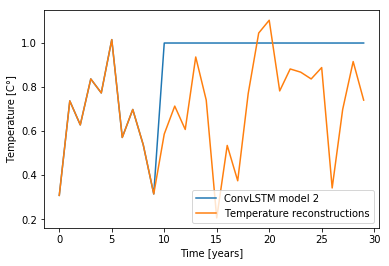

In [14]:
pyplot.figure()
pyplot.plot((Full_prediction[:,34,102,0]), label='ConvLSTM model 2')
pyplot.plot(TT_test_grid[0,:,34,102,0], label='Temperature reconstructions')
pyplot.legend()
pyplot.ylabel("Temperature [C°]")
pyplot.xlabel("Time [years]")
pyplot.show()
